In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tdastro.opsim.ztf_opsim import ZTFOpsim,_ztf_opsim_colnames
from tdastro.astro_utils.passbands import PassbandGroup
from tdastro.astro_utils.pzflow_node import PZFlowNode
from tdastro.astro_utils.snia_utils import (
    DistModFromRedshift,
    HostmassX1Func,
    X0FromDistMod,
)
from tdastro.math_nodes.np_random import NumpyRandomFunc
from tdastro.simulate import simulate_lightcurves
from tdastro.sources.sncomso_models import SncosmoWrapperModel
from tdastro.sources.snia_host import SNIaHost
from tdastro.utils.plotting import plot_lightcurves
from tdastro.math_nodes.ra_dec_sampler import OpSimUniformRADECSampler

from tdastro import _TDASTRO_BASE_DATA_DIR

In [2]:
# Load the OpSim data.
opsim_db = ZTFOpsim.from_db("ztf_metadata_latest.db",sql_query="SELECT * from exposures", colmap=_ztf_opsim_colnames)
t_min, t_max = opsim_db.time_bounds()
print(f"Loaded OpSim with {len(opsim_db)} rows and times [{t_min}, {t_max}]")

#Load the passband data for the griz filters only.
passband_group = PassbandGroup(preset="LSST", filters_to_load=["g", "r", "i"], 
                               units="nm", trim_quantile=0.001, delta_wave=1)
print(f"Loaded Passbands: {passband_group}")

/Users/mi/Work/tdastro/tdastro/src/tdastro/opsim/ztf_opsim.py:143: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.table = self.table.replace("", np.nan)
2025-03-02 17:07:58,051 - INFO - Loading passbands from preset LSST
2025-03-02 17:07:58,051 - INFO - Loading passband from file: /Users/mi/Work/tdastro/tdastro/data/passbands/LSST/u.dat
2025-03-02 17:07:58,057 - INFO - Loading passband from file: /Users/mi/Work/tdastro/tdastro/data/passbands/LSST/g.dat
2025-03-02 17:07:58,063 - INFO - Loading passband from file: /Users/mi/Work/tdastro/tdastro/data/passbands/LSST/r.dat
2025-03-02 17:07:58,067 - INFO - Loading passband from file: /Users/mi/Work/tdastro/tdastro/data/passbands/LSST/i.dat
2025-03-02 17:07:58,073 - INFO - Loading passband from file: /Users/mi/

Loaded OpSim with 864838 rows and times [58197.12385416667, 60247.54819699074]
Loaded Passbands: PassbandGroup containing 3 passbands: LSST_g, LSST_r, LSST_i


In [3]:
# Load the Flow model into a PZFlow node. This gives access to all of the outputs of the
# flow model as attributes of the PZFlowNode.
pz_node = PZFlowNode.from_file(
    _TDASTRO_BASE_DATA_DIR / "model_files" / "snia_hosts_test_pzflow.pkl",  # filename
    node_label="pznode",
)
radec_node = OpSimUniformRADECSampler(opsim_db, radius=2.735, node_label="radec")
# Create a model for the host of the SNIa. The attributes will be sampled via
# the PZFlowNode's model. So each hos instantiation will have its own properties.
# Note: This requires the user to know the output names from the underlying flow model.
host = SNIaHost(
    # ra=NumpyRandomFunc("uniform",low=0.,high=360.),
    # dec=NumpyRandomFunc("uniform",low=-20.,high=90.),
    ra = radec_node.ra,
    dec = radec_node.dec,
    hostmass=pz_node.LOGMASS,
    redshift=NumpyRandomFunc("uniform", low=0.001, high=0.1),
    node_label="host",
)

INFO:2025-03-02 17:07:58,098:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-03-02 17:07:58,098 - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-03-02 17:07:58,100:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/mi/anaconda3/envs/tdastro/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
2025-03-02 17:07:58,100 - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Crypt

In [8]:
distmod_func = DistModFromRedshift(host.redshift, H0=73.0, Omega_m=0.3)
x1_func = HostmassX1Func(host.hostmass)
c_func = NumpyRandomFunc("normal", loc=0, scale=0.02)
m_abs_func = NumpyRandomFunc("normal", loc=-19.3, scale=0.1)
x0_func = X0FromDistMod(
    distmod=distmod_func,
    x1=x1_func,
    c=c_func,
    alpha=0.14,
    beta=3.1,
    m_abs=m_abs_func,
    node_label="x0_func",
)

sncosmo_modelname = "salt3-nir"
source = SncosmoWrapperModel(
    sncosmo_modelname,
    t0=NumpyRandomFunc("uniform", low=t_min, high=t_max),
    x0=x0_func,
    x1=x1_func,
    c=c_func,
    ra=NumpyRandomFunc("normal", loc=host.ra, scale=0.01),
    dec=NumpyRandomFunc("normal", loc=host.dec, scale=0.01),
    redshift=host.redshift,
    node_label="source",
)

In [9]:
lightcurves = simulate_lightcurves(source, 1000, opsim_db, passband_group)
print(lightcurves)

/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


      id          ra        dec  nobs  \
0      0  100.395714  27.109627    11   
1      1  182.601505 -13.839217     0   
2      2  142.631600  22.959928     4   
3      3   39.898234  39.022702    44   
4      4  211.766846  71.248425    29   
..   ...         ...        ...   ...   
995  995  285.302213  51.338663     7   
996  996  213.972188  36.322020     0   
997  997  178.119341  56.947274    24   
998  998  283.824627  10.076907    18   
999  999  331.364342   1.810811     1   

                                                params  \
0    {'radec.ra': 100.40020617835202, 'radec.dec': ...   
1    {'radec.ra': 182.59480965541084, 'radec.dec': ...   
2    {'radec.ra': 142.62018201208053, 'radec.dec': ...   
3    {'radec.ra': 39.904019386907784, 'radec.dec': ...   
4    {'radec.ra': 211.76620879369915, 'radec.dec': ...   
..                                                 ...   
995  {'radec.ra': 285.29419496680646, 'radec.dec': ...   
996  {'radec.ra': 213.9763770597418, 'radec

In [10]:
lightcurves.lightcurve.isna().sum()

362

/var/folders/zs/zxl3t6ks12zg2l3dp9qn1rkr0000gn/T/ipykernel_81902/142081240.py:14: RuntimeWarning: invalid value encountered in log10
  lc_mag = -2.5*np.log10(lc_flux) + 31.4


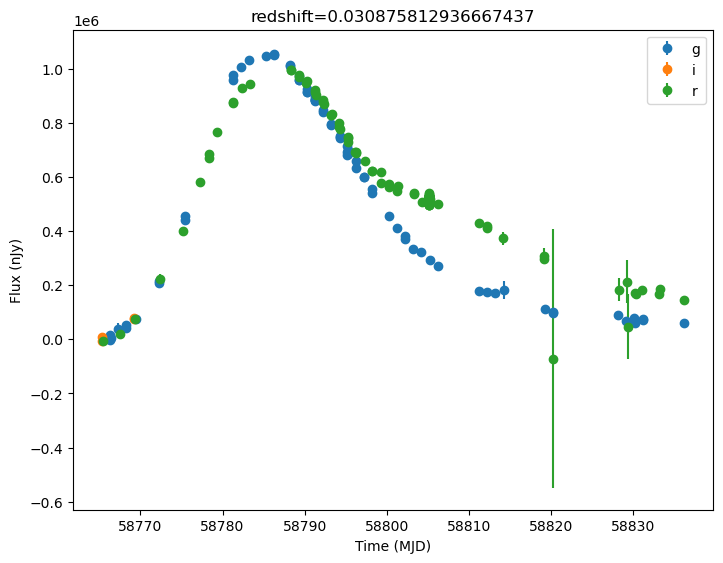

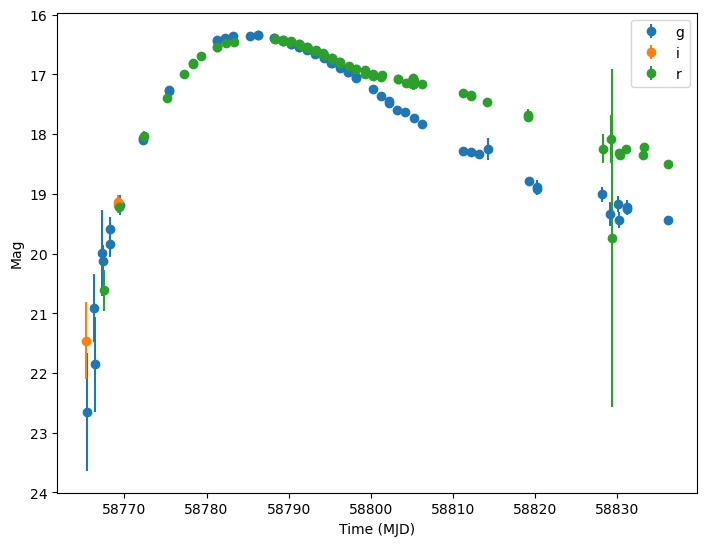

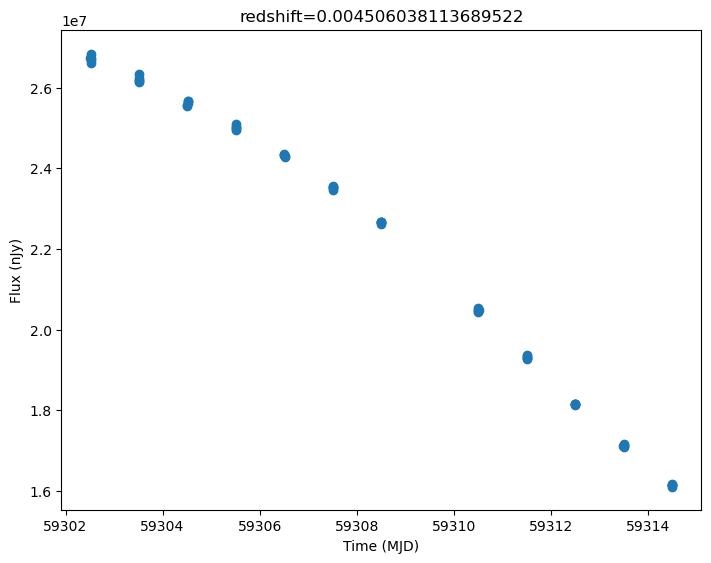

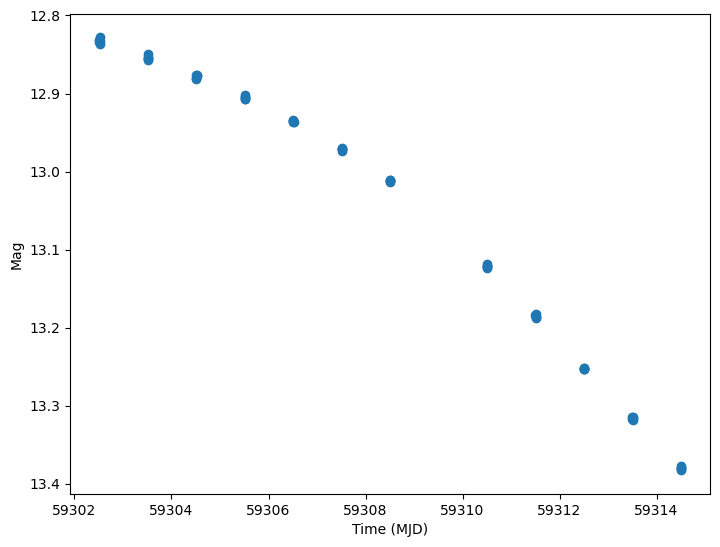

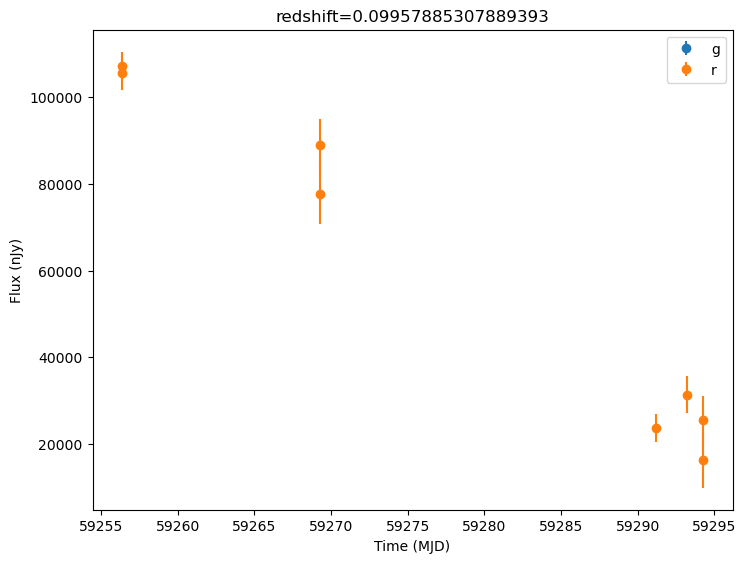

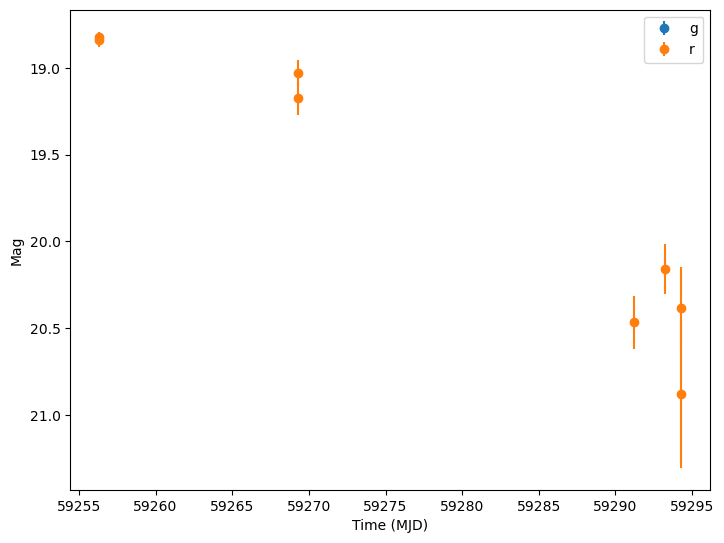

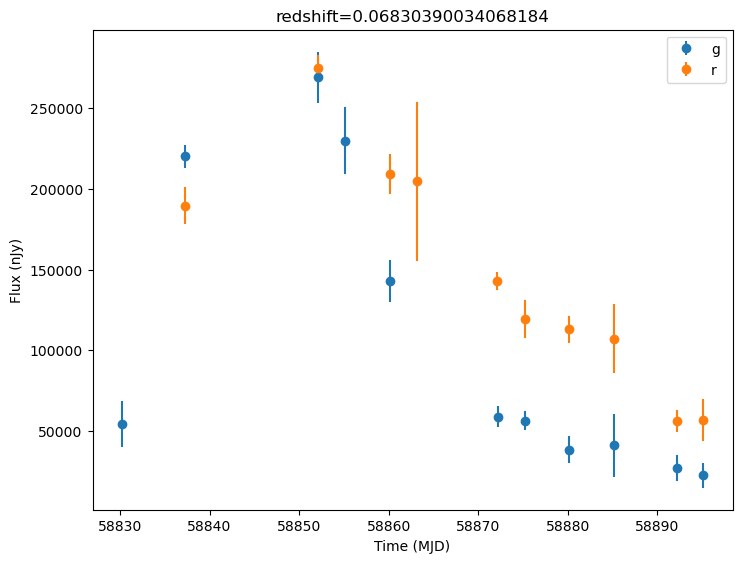

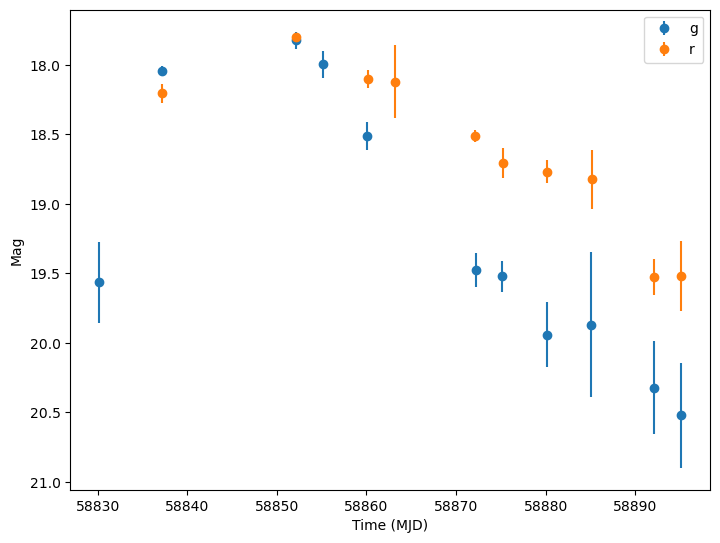

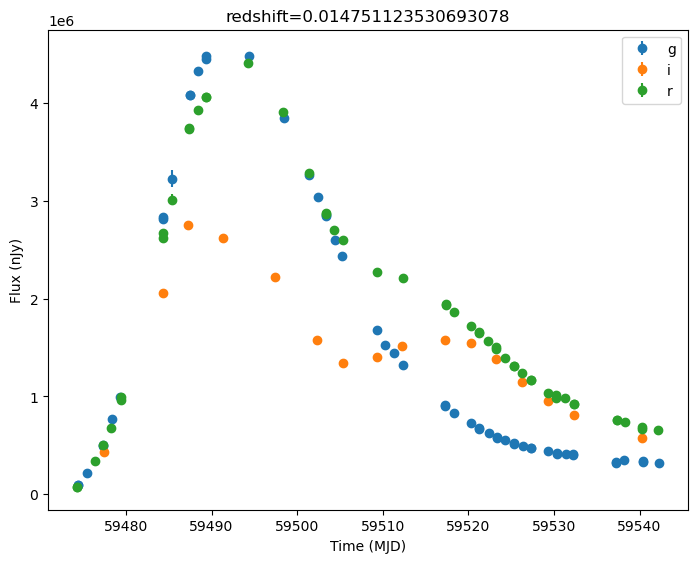

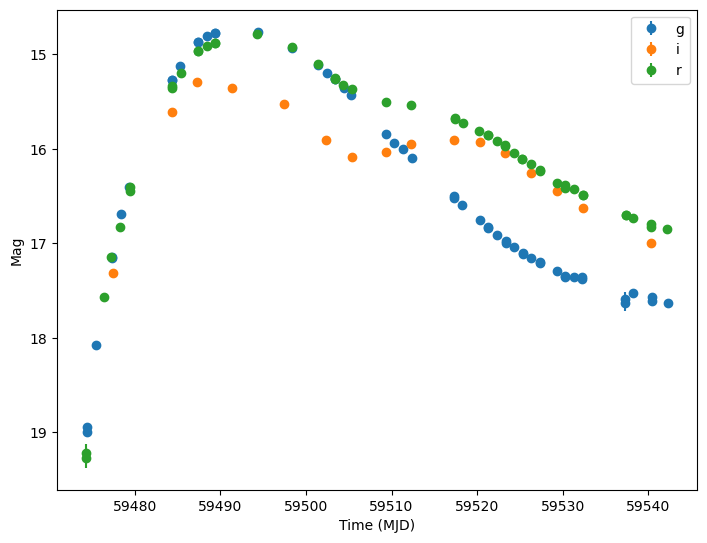

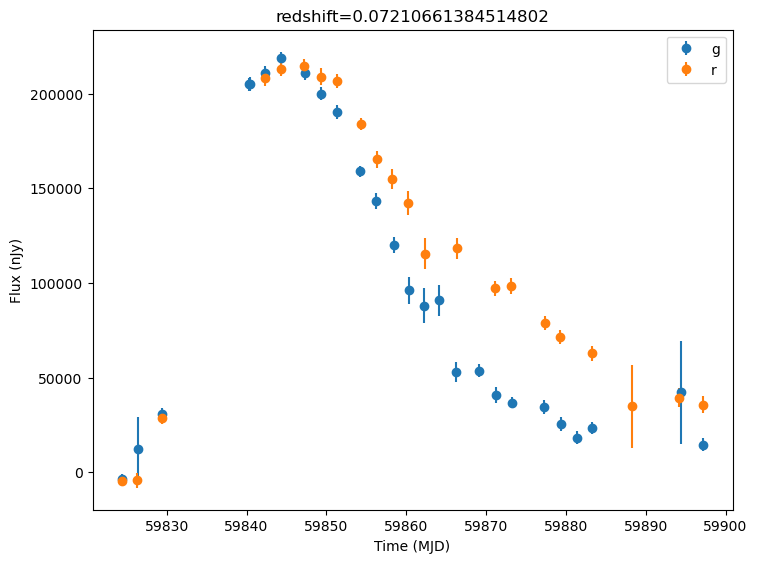

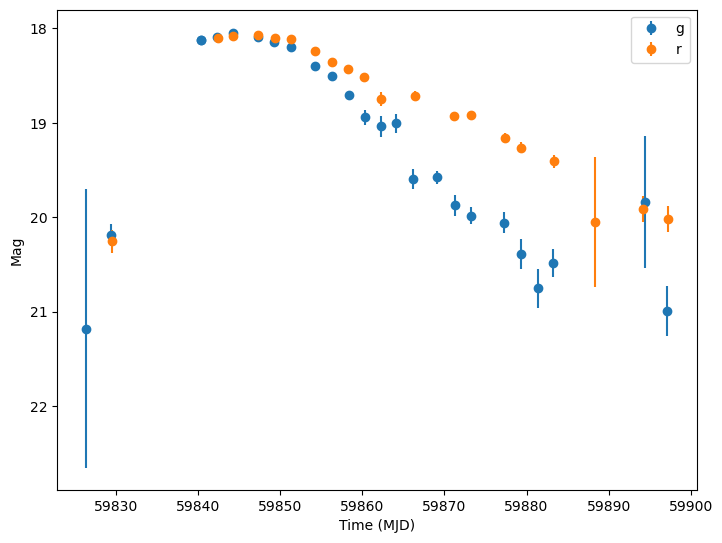

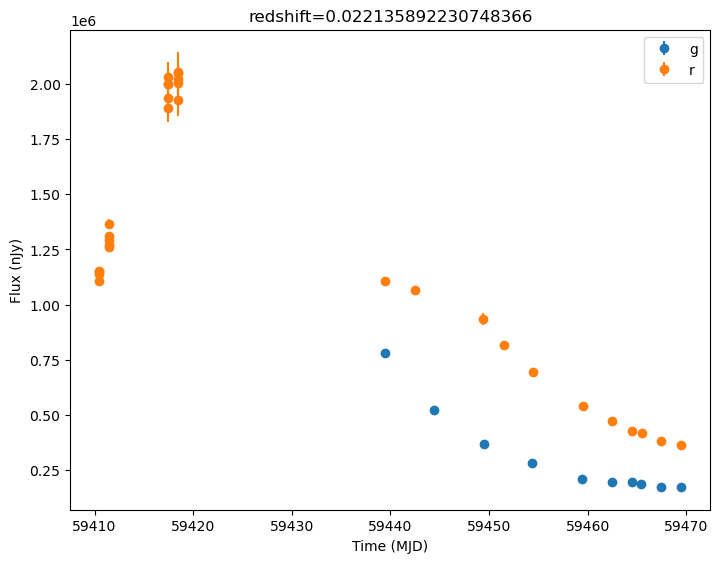

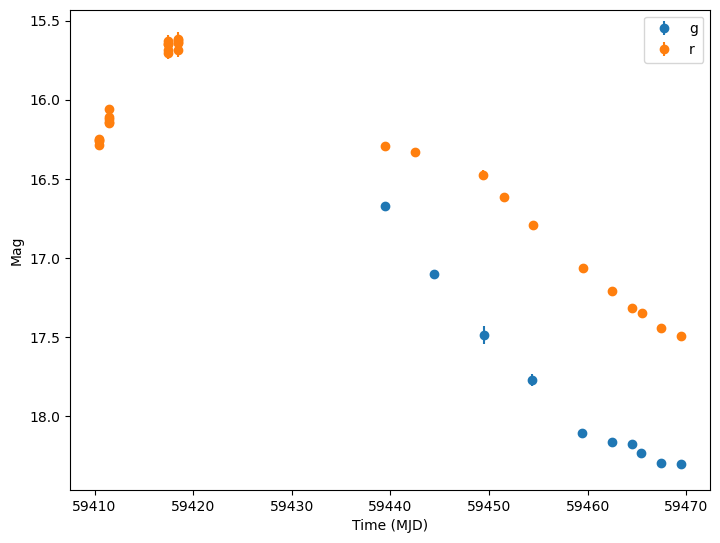

In [11]:
random_ids = np.random.choice(len(lightcurves), 10)

for random_id in random_ids:
    # Extract the row for this object.
    lc = lightcurves.loc[random_id]
    
    if lc["nobs"] > 0:
        # Unpack the nested columns (filters, mjd, flux, and flux error).
        lc_filters = np.asarray(lc["lightcurve"]["filter"], dtype=str)
        lc_mjd = np.asarray(lc["lightcurve"]["mjd"], dtype=float)
        lc_flux = np.asarray(lc["lightcurve"]["flux"], dtype=float)
        lc_fluxerr = np.asarray(lc["lightcurve"]["fluxerr"], dtype=float)

        lc_mag = -2.5*np.log10(lc_flux) + 31.4
        lc_magerr = np.absolute(1.086*lc_fluxerr/lc_flux)
        
        plot_lightcurves(
            fluxes=lc_flux,
            times=lc_mjd,
            fluxerrs=lc_fluxerr,
            filters=lc_filters,
        )
        plt.ylabel('Flux (nJy)')
        plt.title(f"redshift={lc['params']['host.redshift']}")
        plt.show()
        
        plot_lightcurves(
            fluxes=lc_mag,
            times=lc_mjd,
            fluxerrs=lc_magerr,
            filters=lc_filters,
        )
        plt.ylabel('Mag')
        plt.ylim(plt.ylim()[::-1])
        plt.show()